
# <span style="color:rgb(213,80,0)">Unsupervised Classification Tutorial</span>

**Sean Osis, Allan Brett, Reed Ferber, Reginaldo Fukuchi, Blayne Hettinga**

### Purpose

The purpose of this tutorial is to demonstrate the application of techniques for:

-  Removing outliers from a set of discrete kinematic variables using a one\-class support vector machine
-  Conducting unsupervised clustering using hierarchical cluster analysis (HCA) to find groups
-  Interpreting group membership using statistical analysis
-  Using a replicate data set to determine the stability of identified groups

**Requirements**

-  MATLAB 2016a or later and a supported OS
-  MATLAB Statistics and Machine Learning Toolbox
-  Code package included with supplemental material
-  Open access data set included with supplemental material
-  Files from Mathworks File Exchange
### Load Meta Data

In this section, data are loaded from CSV files that have been included with this project. The CSV files contain metadata tabulated for all subjects.


In [1]:
% Format number display
format bank

In [2]:
% Point to the data folders
% Modify these directories as required
jsondir = '../Output_folder/reformat_data';
csvdir  = '../Output_folder';

% Obtain list of JSONs
jsons = dir(fullfile(jsondir, '/*/*.json'));
csvs  = dir(fullfile(csvdir, '*.csv'));

jsons(1)

ans = struct with fields:
       name: '20110531T161051.json'
eformat_data\100001'
       date: '08-Mar-2023 12:48:00'
      bytes: 7244825.00
      isdir: 0
    datenum: 738953.53

In [3]:
csvs(1)

ans = struct with fields:
       name: 'run_data_meta.csv'
     folder: 'Z:\Figshare Project\Output_folder'
       date: '02-May-2023 08:45:28'
      bytes: 389279.00
      isdir: 0
    datenum: 739008.36

In [4]:
% Load CSVs and extract required variables

csv_ = cell(length(csvs),1);
for i = 1:length(csvs)
    csv_{i} = readtable(fullfile(csvs(i).folder, csvs(i).name));
    if contains(csvs(i).name, 'run')
        csv_{i}.gaitspeed = csv_{i}.speed_r;
        csv_{i}.gaittype(:)  = "run";
        csv_{i}.speed_r = [];
    else
        csv_{i}.gaitspeed = csv_{i}.speed_w;
        csv_{i}.gaittype(:)  = "walk";
        csv_{i}.speed_w = [];
    end
end

csv_ = vertcat(csv_{:});

csv_ = csv_(:, {'sub_id','datestring','filename','age','Gender','Height','Weight','gaitspeed','gaittype','InjDefn'});

size(csv_)

ans = 1x2
       3920.00         10.00

In [5]:

csv_.Properties.VariableNames'

ans = 10x1 cell
'sub_id'    
'datestring'
'filename'  
'age'       
'Gender'    
'Height'    
'Weight'    
'gaitspeed' 
'gaittype'  
'InjDefn'

In [6]:
% Filter out subjects with missing data
csv_ = rmmissing(csv_,1);

% Remove walking data
csv_ = csv_(csv_.gaittype == "run",:);

% Remove subjects outside age bounds
csv_ = csv_(csv_.age >= 20 & csv_.age <= 65,:);

In [7]:
% Quantiles for height and mass
p = 0:0.1:1;

disp('Quantiles for Height')

Quantiles for Height

In [8]:
y = quantile(csv_.Height,p);
disp([p;y])

  Columns 1 through 9
             0          0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80
             0        160.00        164.33        167.00        170.00        172.60        175.00        178.00        180.40
  Columns 10 through 11
          0.90          1.00
        184.00        999.00

In [9]:

disp('Quantiles for Mass')

Quantiles for Mass

In [10]:
y = quantile(csv_.Weight,p);
disp([p;y])

  Columns 1 through 9
             0          0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80
             0         54.74         58.63         62.00         65.51         69.30         72.79         76.70         81.00
  Columns 10 through 11
          0.90          1.00
         87.76       1564.00

In [11]:
% Filter out erroneous height and mass data
csv_ = csv_(csv_.Height > 0 & csv_.Height < 999,:);
csv_ = csv_(csv_.Weight > 0 & csv_.Weight < 100,:);

In [12]:
disp('Quantiles for Height')

Quantiles for Height

In [13]:
y = quantile(csv_.Height,p);
disp([p;y])

  Columns 1 through 9
             0          0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80
        120.00        160.00        164.00        167.00        170.00        172.00        175.00        177.47        180.00
  Columns 10 through 11
          0.90          1.00
        183.60        196.50

In [14]:

disp('Quantiles for Mass')

Quantiles for Mass

In [15]:
y = quantile(csv_.Weight,p);
disp([p;y])

  Columns 1 through 9
             0          0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80
         42.50         54.70         58.20         62.00         65.20         68.75         72.01         76.00         80.00
  Columns 10 through 11
          0.90          1.00
         86.00         99.70

### Load Biomechanics Data

In this section, corresponding JSONs are loaded into memory and discrete variables are extracted.


In [16]:
% Load and cache data for pipeline efficiency - 2 hours to load all data
if isfile('tutorial_4_cache.mat')

    % Load cached file
    load('tutorial_4_cache.mat')

else

    dv_w = cell(height(csv_),1);
    dv_r = dv_w;

    for i = 1:height(csv_)

        json_file = fullfile(jsondir, num2str(csv_.sub_id(i)),csv_.filename{i});
        fid = fopen(json_file);
        raw = fread(fid,inf);
        str = char(raw');
        fclose(fid);
        out = jsondecode(str);
        dv_w{i,1} = out.dv_w;
        dv_r{i,1} = out.dv_r;

        if mod(i,10) == 0
            disp(['Completed ' num2str(i/height(csv_)*100,'%.1f') '% of files'])
        end

    end

    save('tutorial_4_cache.mat','dv_r','dv_w','csv_')

    disp('All files loaded')

end

Completed 0.6% of files
Completed 1.2% of files
Completed 1.9% of files
Completed 2.5% of files
Completed 3.1% of files
Completed 3.7% of files
Completed 4.4% of files
Completed 5.0% of files
Completed 5.6% of files
Completed 6.2% of files
Completed 6.8% of files
Completed 7.5% of files
Completed 8.1% of files
Completed 8.7% of files
Completed 9.3% of files
Completed 10.0% of files
Completed 10.6% of files
Completed 11.2% of files
Completed 11.8% of files
Completed 12.5% of files
Completed 13.1% of files
Completed 13.7% of files
Completed 14.3% of files
Completed 14.9% of files
Completed 15.6% of files
Completed 16.2% of files
Completed 16.8% of files
Completed 17.4% of files
Completed 18.1% of files
Completed 18.7% of files
Completed 19.3% of files
Completed 19.9% of files
Completed 20.5% of files
Completed 21.2% of files
Completed 21.8% of files
Completed 22.4% of files
Completed 23.0% of files
Completed 23.7% of files
Completed 24.3% of files
Completed 24.9% of files
Completed 25.5%

### Reshape Data Into Tables

This section extracts discrete values from the data structure and reshapes them into a rectangular matrix that can be used as an input for classification functions.


In [17]:
% Organize running variables into arrays

for i = 1:length(dv_r)

    fn = fieldnames(dv_r{i}.right);

    tf = cellfun(@(c) isempty(dv_r{i}.right.(c)), fn);
    if any(tf)
        dv_r{i}.right.(fn{tf}) = NaN;
    end

    tf = cellfun(@(c) isempty(dv_r{i}.left.(c)), fn);
    if any(tf)
        dv_r{i}.left.(fn{tf}) = NaN;
    end

    row_r = struct2table(dv_r{i}.right,'AsArray',true);
    row_l = struct2table(dv_r{i}.left, 'AsArray',true);

    if i == 1
        dv_r_r = row_r;
        dv_r_l = row_l;
    else
        dv_r_r = outerjoin(dv_r_r, row_r, 'MergeKeys', true);
        dv_r_l = outerjoin(dv_r_l, row_l,  'MergeKeys', true);
    end
end

In [18]:
% Concatenate left and right tables and add metadata

colnames = dv_r_r.Properties.VariableNames;
newnames = lower(append(colnames,'_right'));
dv_r_r = renamevars(dv_r_r, colnames, newnames);

colnames = dv_r_l.Properties.VariableNames;
newnames = lower(append(colnames,'_left'));
dv_r_l = renamevars(dv_r_l, colnames, newnames);

arr_dv_r = horzcat(csv_, dv_r_l, dv_r_r);


In this tutorial we will focus on frontal and sagittal plane variables. Transverse plane kinematics are often more variable and exhibit increased noise that will compound the challenges of discovering clusters in a large data set.


In [19]:
% Specify columns to use in analysis

subcols =  {'step_width_left', 'stride_rate_left', 'stride_length_left', ...
            'pelvis_peak_drop_angle_left','pelvis_drop_excursion_left','ankle_df_peak_angle_left', ...
            'ankle_eve_peak_angle_left','ankle_eve_percent_stance_left','ankle_eve_excursion_left', ...
            'knee_flex_peak_angle_left', ...
            'knee_add_peak_angle_left','knee_add_excursion_left','knee_abd_peak_angle_left', ...
            'knee_abd_excursion_left', ...
            'hip_ext_peak_angle_left','hip_add_peak_angle_left','hip_add_excursion_left', ...
            'foot_prog_angle_left', ...
            'foot_ang_at_hs_left', ...
            'step_width_right','stride_rate_right','stride_length_right', ...
            'pelvis_peak_drop_angle_right','pelvis_drop_excursion_right','ankle_df_peak_angle_right', ...
            'ankle_eve_peak_angle_right','ankle_eve_percent_stance_right','ankle_eve_excursion_right', ...
            'knee_flex_peak_angle_right', ...
            'knee_add_peak_angle_right','knee_add_excursion_right','knee_abd_peak_angle_right', ...
            'knee_abd_excursion_right', ...
            'hip_ext_peak_angle_right','hip_add_peak_angle_right','hip_add_excursion_right', ...
            'foot_prog_angle_right', ...
            'foot_ang_at_hs_right'};

### Data Pre\-Processing

In this section, data are split into two replicates in order to examine cluster stability, and the "training" set is prepared for anlaysis \[1\].


In [20]:
% Split into train and validation sets
[m,n] = size(arr_dv_r);
P = 0.50;
rng(2023); % Seed for reproducibility
idx = randperm(m);
arr_train = arr_dv_r(idx(1:round(P*m)),:);
arr_testt = arr_dv_r(idx(round(P*m)+1:end),:);


Here, we test for normality of the discrete variables. This is useful in order to assess which methods might be used for outlier removal, or how we might perform inferential statistics. In this case, two Henze\-Zirkler tests are run on left leg and right leg data sets separately in order to avoid singularities when computing the test \[2\].


In [21]:
% Test normality using HZ test
HZmvntest(table2array(arr_train(:,subcols(1:25))));

 
Henze-Zirkler's Multivariate Normality Test
-------------------------------------------------------------------
Number of variables: 25
Sample size: 803
-------------------------------------------------------------------
Henze-Zirkler lognormal mean: -0.0000783
Henze-Zirkler lognormal variance: 0.0000773
Henze-Zirkler statistic: 3212.0000000
P-value associated to the Henze-Zirkler statistic: 0.0000000
With a given significance = 0.050
-------------------------------------------------------------------
Data analyzed do not have a normal distribution.
-------------------------------------------------------------------

In [22]:
HZmvntest(table2array(arr_train(:,subcols(26:end))));

 
Henze-Zirkler's Multivariate Normality Test
-------------------------------------------------------------------
Number of variables: 13
Sample size: 803
-------------------------------------------------------------------
Henze-Zirkler lognormal mean: -0.0035167
Henze-Zirkler lognormal variance: 0.0029510
Henze-Zirkler statistic: 1.2667794
P-value associated to the Henze-Zirkler statistic: 0.0000000
With a given significance = 0.050
-------------------------------------------------------------------
Data analyzed do not have a normal distribution.
-------------------------------------------------------------------


The data do not appear to demonstrate normality according to the HZ test, so we must be cautious about using any tests or analyses that assume normality. For example, standardizing the data by normalizing to the mean and standard deviation may result in undesireable effects, therefore, we apply median absolute deviation (MAD) scaling instead. MAD also has the benefit of being robust to outliers and mixed distributions \[3,4\].


In [23]:
% Rescale data using median absolute deviation
arr_scale = normalize(table2array(arr_train(:,subcols)),'scale','mad');


A one\-class SVM is a useful method for anomaly detection and removal, particularly with well scaled data. However, it can suffer from overfitting, and therefore a crossvalidation step is required \[5\].



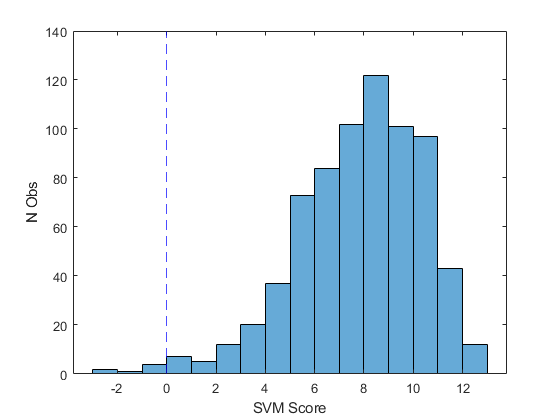

In [24]:
% Use one-class SVM to remove outliers

rng(10); % For reproducibility
ocsvmk = fitcsvm(arr_scale,ones(length(arr_scale),1),'KernelScale','auto','Standardize',false,'CrossVal','on','Holdout',0.9);
[~,score] = kfoldPredict(ocsvmk);

figure;
histogram(score); hold on;
xline(0,'--b')
xlabel('SVM Score')
ylabel('N Obs')

In [25]:
indrm = find(score<0);
arr_scale(indrm,:) = [];
arr_train(indrm,:) = [];

### Hierarchical Cluster Analysis

There are several approaches to unsupervised clustering, however, we will use HCA in this example due to the fact that we do not need to assume a set number of size of clusters or search pattern, and HCA is computationally very efficient.


In [26]:
hca_arr = arr_scale;


We first attempt to use a euclidean distance metric with Ward's linkage. This is a relatively standard approach, even though it may produce a low cophenetic correlation \[6,7\].


In [27]:
Y = pdist(hca_arr,'euclidean');
Z = linkage(Y,'ward');
cophenet(Z,Y)

ans = 
          0.26


The dendrogram indicates two high\-level divisions in the tree, followed by a series of smaller divisions for the left grouping. The choice of how to partition the data can be somewhat subjective, but in general, the taller and further apart the linkages, the more dissimilarity (and likely interest) there is between clusters. For example purposes, we will choose only 4 clusters, but this dendrogram may support selecting more than that.



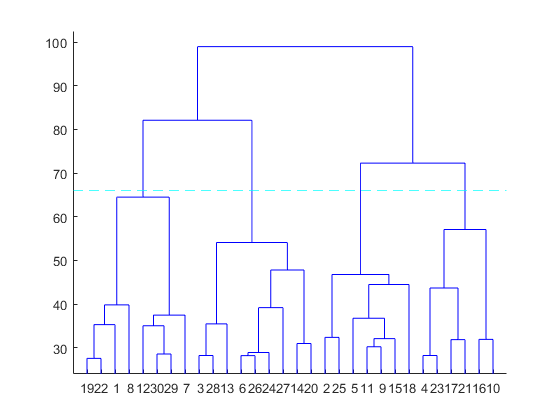

In [28]:
figure;
dendrogram(Z)
yline(66,'--c')

In [29]:
ngrps = 4;
T_train = cluster(Z,'maxclust',ngrps);

In [30]:
table(groupcounts(T_train),'VariableNames',{'Count'})


In order to assess whether there are statistical differences between clusters, we can apply a non\-parametric multigroup test, such as Kruskal\-Wallis, to the original un\-scaled data. The implementation used here does not allow for both mutligroup and multivariate analyses, so we will test each variable separately and then correct all of our tests using a Holm\-Bonferroni correction \[8\].


It is important to note that any statistical inference in this case will be *biased*, as we have constructed the clusters ourselves based on the mathematical fact that they are inherently dissimilar. In this case, we are using statistical analysis to guide our determination of which variables are most discriminatory, rather than making inferences about subpopulations of runners.


In [31]:
% Determine any significant differences in original vars among groups
p = zeros(length(subcols),1);
stats = cell(length(subcols),1);
c = ones(nchoosek(ngrps,2),6,length(subcols));
for i = 1:length(subcols)
    [p(i),~,stats{i}] = kruskalwallis(table2array(arr_train(:,subcols{i})),T_train,'off');
    if p(i) < 0.05
        c(:,:,i) = multcompare(stats{i},'Display','off');
    end
end
[p_hb,h_hb] = bonf_holm(c(:,6,:),0.05);


We can use the proportion of positive corrected tests for each variable to determine which groups demonstrate the most differences between each other.  Those groups are more likely to demonstrate repeatable separation, and reveal the variables that are most discriminatory between groups.



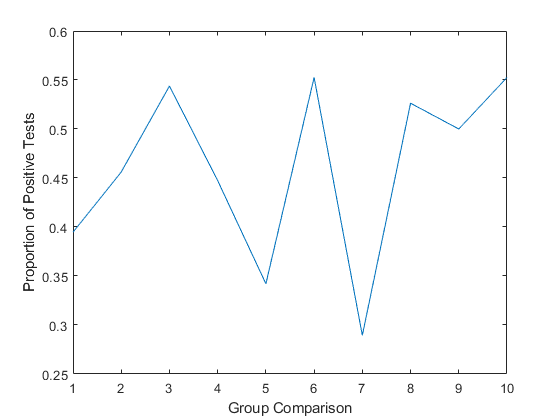

In [32]:
% Try maximizing proportion of positive tests for subsets
sets = 1:ngrps;

set = false(0,ngrps);
for i = 1:ngrps-2
    set = vertcat(set,permpos(i,ngrps));
end

pp_ha = zeros(length(set),1);
for j = 1:length(set)
    sub = h_hb(~ismember(c(:,1),sets(set(j,:))) & ~ismember(c(:,2),sets(set(j,:))),:,:);
    pp_ha(j) = sum(sum(sub))/numel(sub);
end

figure;
plot(pp_ha)
xlabel('Group Comparison')
ylabel('Proportion of Positive Tests')

In [33]:
setind = ~set(pp_ha==max(pp_ha),:);
diffgrps = zeros(0);
for i = 1:size(setind,1)
    diffgrps = horzcat(diffgrps, sets(setind(i,:)));
end
diffgrps = unique(diffgrps);
cind = find(((ismember(c(:,1),diffgrps) & ismember(c(:,2),diffgrps))));
diffgrps

diffgrps = 1x3
1.00          2.00          4.00


We now have a set of groups that are most different from one another. Next, we can use the ranks from the KW tests between those disparate groups to determine which variables show the most dissimilarity between the groups.



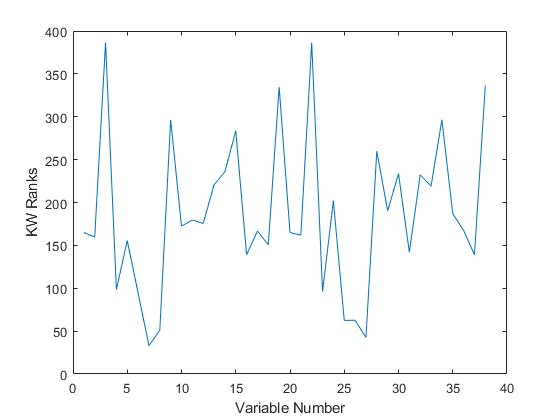

In [34]:
varanks = cell(length(subcols),length(diffgrps));

for i = 1:length(diffgrps)
    varanks(:,i) = cellfun(@(x) x.meanranks(diffgrps(i)),stats,'un',0);
end

varanks = cell2mat(varanks);
varanks = horzcat(varanks,range(varanks,2));

figure;
plot(varanks(:,end));
xlabel('Variable Number')
ylabel('KW Ranks')

In [35]:

varanks = horzcat(varanks,squeeze(sum(h_hb(cind,:,:),1)));

[~,topi] = topkrows(varanks,10,size(varanks,2)-1:size(varanks,2));
subcols(topi)'

ans = 10x1 cell
'stride_length_left'       
'stride_length_right'      
'foot_ang_at_hs_right'     
'foot_ang_at_hs_left'      
'hip_ext_peak_angle_right' 
'ankle_eve_excursion_left' 
'hip_ext_peak_angle_left'  
'ankle_eve_excursion_right'
'knee_abd_excursion_left'  
'knee_add_peak_angle_right'


Now, we have a list of the most discriminating variables between clusters, and we can visually compare groups by each variable and start to determine an interpretation of group membership.



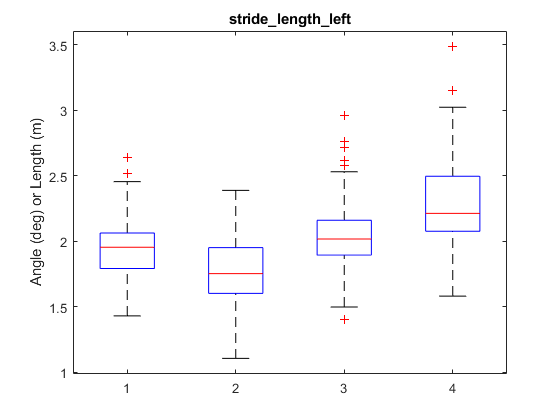


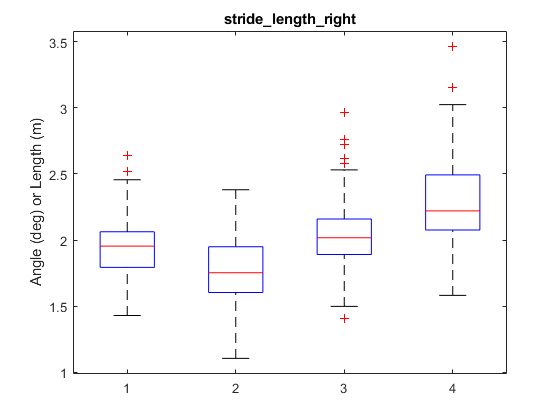

In [36]:
for i = 1:length(topi)
    figure; hold on;
    boxplot(table2array(arr_train(:,subcols(topi(i)))),T_train);
    title(subcols(topi(i)),'Interpreter','none')
    ylabel('Angle (deg) or Length (m)')
end

<center>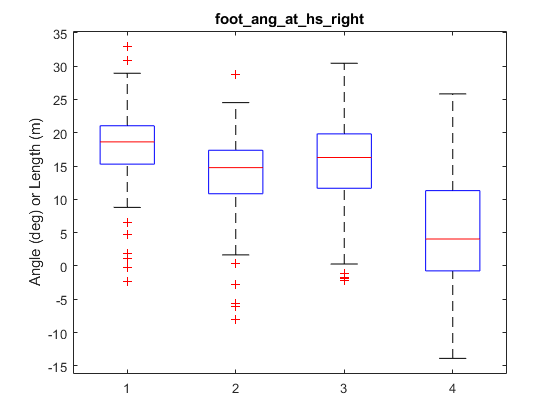</center>


<center>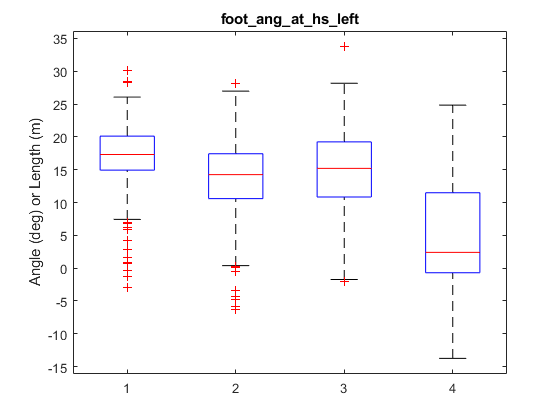</center>


<center>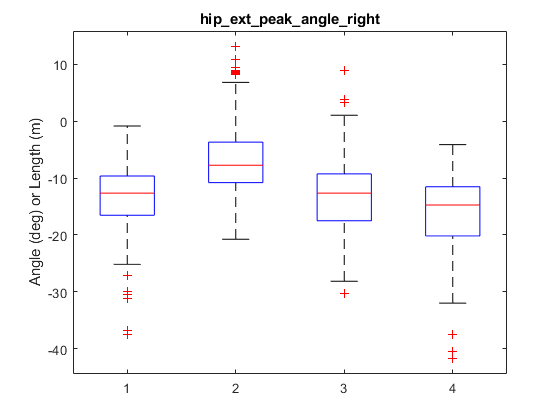</center>


<center>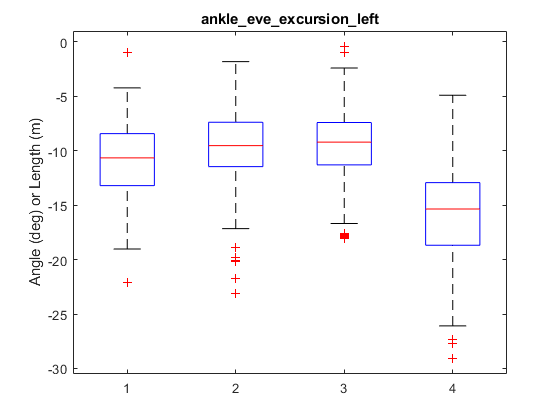</center>


<center>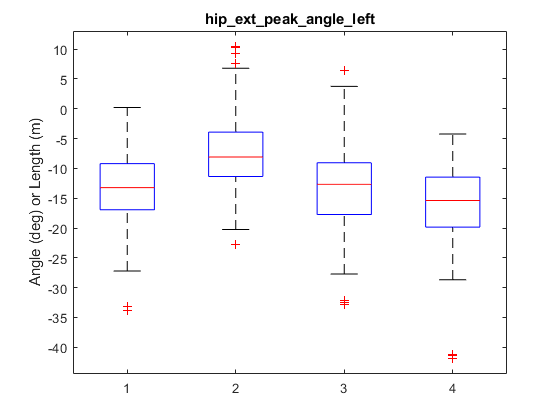</center>


<center>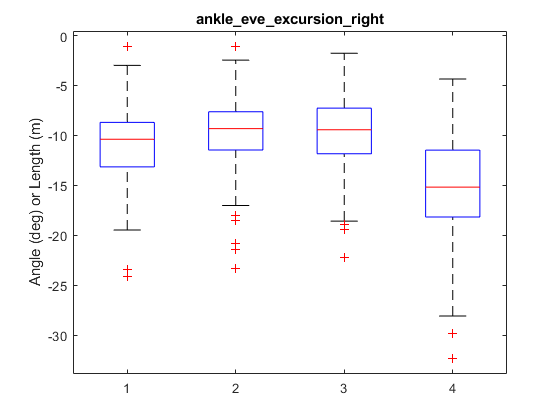</center>


<center>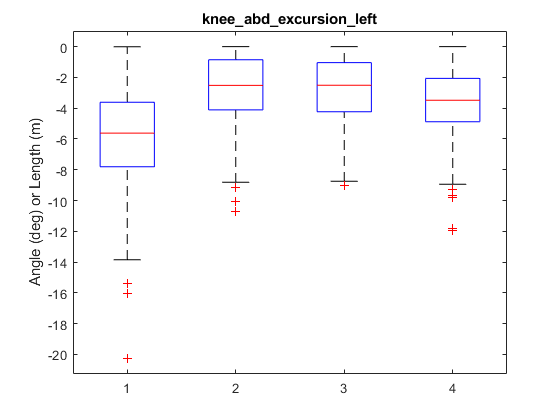</center>


<center>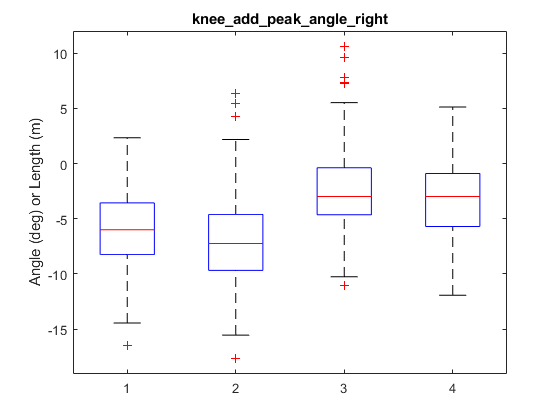</center>


One finding of interest is the groupings for stride length and foot angle at touchdown. It is apparent that some runners exhibit a more midfoot/forefoot striking pattern, coupled with a longer stride rate. Biomechanically, this is a sensical result if stride frequency is similar between the groups, as forefoot strikers have been shown to alter either stride rate or stride length as compared with rearfoot strikers \[11\]. From the figure below of stride rate, it is apparent that group 4 trends towards higher frequency, but the difference is not as distinct as for stride length. The trend towards longer strides is further supported by the comparison of hip extension, in which the midfoot/forefoot group exhibits larger peak angles at toeoff.



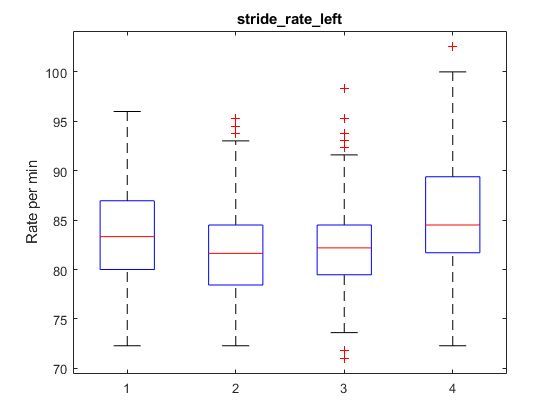

In [37]:
figure; hold on;
boxplot(table2array(arr_train(:,'stride_rate_left')),T_train);
title('stride_rate_left','Interpreter','none')
ylabel('Rate per min')



Next, we can examine whether there are any other subject differences that might impact group membership. This can be accomplished using KW tests for continuous numerical data, and Tukey's HSD test to compare male to female proportions \[10\].


In [38]:
demcols = {'Height','Weight','gaitspeed','age'};

In [39]:
% Determine any significant differences in original vars among groups
for i = 1:length(demcols)
    display(demcols{i})
    [~,tbl,sta] = kruskalwallis(table2array(arr_train(:,demcols{i})),T_train,'off');
    display(tbl)
    if tbl{2,6} < 0.05
        mc = multcompare(sta,'Display','off');
        display(mc)
    end
end

Height

Weight

gaitspeed

mc = 6x6
1.0000    2.0000 -112.0183  -51.4183    9.1818    0.1288
2. 0000    3.0000  -65.3180   -7.9531   49.4118    0.9845
3. 0000    4.0000  -32.3462   31.8584   96.0630    0.5791
    2.0000    3.0000  -12.2806   43.4652   99.2109    0.1868
    2.0000    4.0000   20.5145   83.2767  146.0389    0.0036
    3.0000    4.0000  -19.8329   39.8115   99.4560    0.3159
age


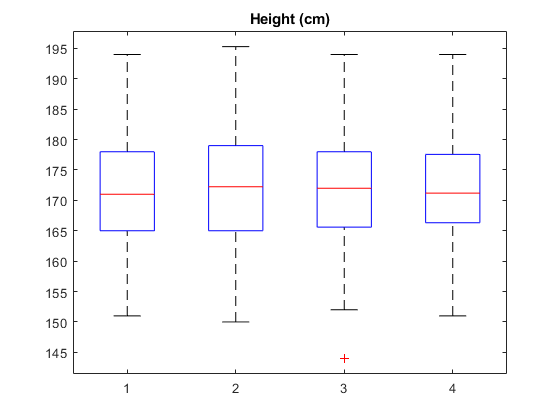

In [40]:
figure; hold on;
boxplot(table2array(arr_train(:,'Height')),T_train);
title('Height (cm)','Interpreter','none')


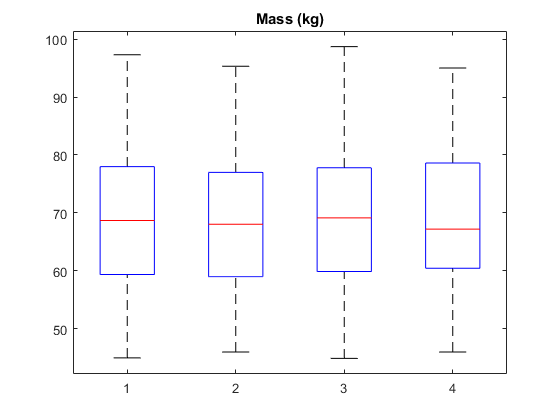

In [41]:
figure; hold on;
boxplot(table2array(arr_train(:,'Weight')),T_train);
title('Mass (kg)','Interpreter','none')


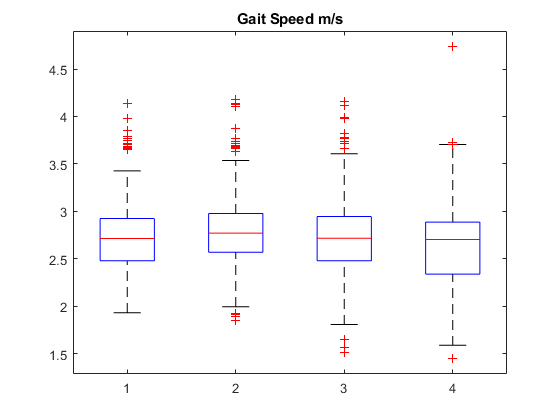

In [42]:
figure; hold on;
boxplot(table2array(arr_train(:,'gaitspeed')),T_train);
title('Gait Speed m/s','Interpreter','none')


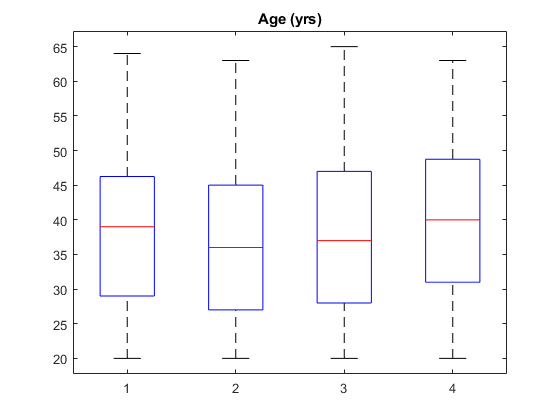

In [43]:
figure; hold on;
boxplot(table2array(arr_train(:,'age')),T_train);
title('Age (yrs)','Interpreter','none')

In [44]:
[mns,num] = grpstats(double(strcmp('Male',table2array(arr_train(:,'Gender')))),T_train,{'mean','numel'});
prop = horzcat(mns.*num,num);
tmcomptest(prop)

ss = 1x4
     1     2     3     4
ps = 4x1
    0.4751
    0.4750
    0.4688
    0.5031
 
Group proportions of the interested events are:
-------------------------------------------
Group          Proportions
-------------------------------------------
  1               0.4751
  2               0.4750
  3               0.4688
  4               0.5031
-------------------------------------------
 
Tukey's multiple comparisions test among proportions, k = 4
-------------------------------------------------------------------------
 Comparision      Difference*        SE        q        qc      Decision
-------------------------------------------------------------------------
    4  3            1.9637         2.043     0.961     3.633       NS
    4  2            1.6049         2.149     0.747     3.633       NS
    4  1            1.5963         2.199     0.726     3.633       NS
    3  2            0.3588         1.910     0.188     3.633       NS
    3  1            0.3674         1.965 


None of the demographic variables demonstrated differences between the groups, so we cannot currently support any effect of demographics on group membership, however, gaitspeed was significanly different between two of the groups, although upon inspection, though the difference may be statistically significant, it is not clear whether it is large enough to be biomechanically significant.

### Replicate Analysis

In order to determine whether we can reliably make an inference about runner subpopulations based on the HCA, we should attempt to reproduce the same clusters using the second replicate data set, the "test" set. If we can reproduce similar clusters through an unsupervised method, this suggests that these phenonema are repeatable and may reliably describe running patterns in the general population.


In [45]:
% Rescale data using MAD
arr_scale = normalize(table2array(arr_testt(:,subcols)),'scale','mad');


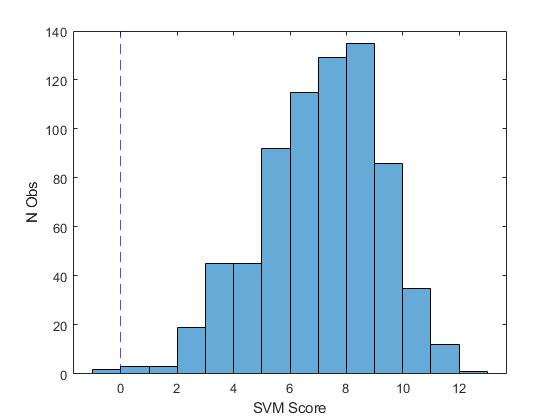

In [46]:
% Use one-class SVM to remove outliers

rng(10); % For reproducibility
ocsvmk = fitcsvm(arr_scale,ones(length(arr_scale),1),'KernelScale','auto','Standardize',false,'CrossVal','on','Holdout',0.9);
[~,score] = kfoldPredict(ocsvmk);

figure;
histogram(score); hold on;
xline(0,'--b')
xlabel('SVM Score')
ylabel('N Obs')

In [47]:
indrm = find(score<0);
arr_scale(indrm,:) = [];
arr_testt(indrm,:) = [];


For replication, we will focus on the top discriminatory variables that were identified from the "training" set. This may have the consequence of biasing the analysis towards a set of features or patterns, but the goal is to determine whether it is possible to replicate our earlier findings with respect to a specific biomechanical pattern, so it is justifiable to focus on the most relevant variables.


In [48]:
hca_arr = arr_scale(:,varanks(:,end)>0);

In [49]:
Y = pdist(hca_arr,'euclidean');
Z = linkage(Y,'ward');
cophenet(Z,Y)

ans = 0.2622


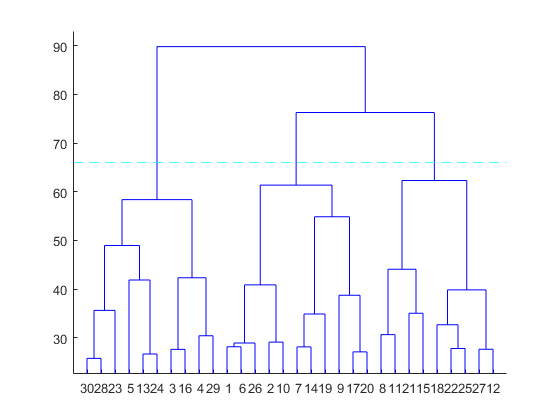

In [50]:
figure;
dendrogram(Z)
yline(66,'--c')


As with the analysis of the "training" set, there are many possible choices for a number of clusters to select. In keeping with the original analysis, we will choose only 4, but the dendrogram likely supports more than that.


In [51]:
ngrps = 4;
T_test = cluster(Z,'maxclust',ngrps);

In [52]:
table(groupcounts(T_test),'VariableNames',{'Count'})


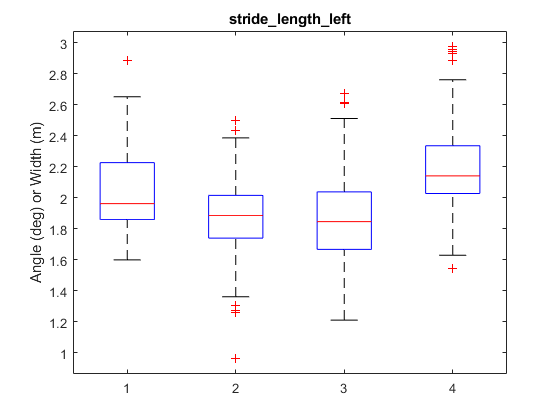


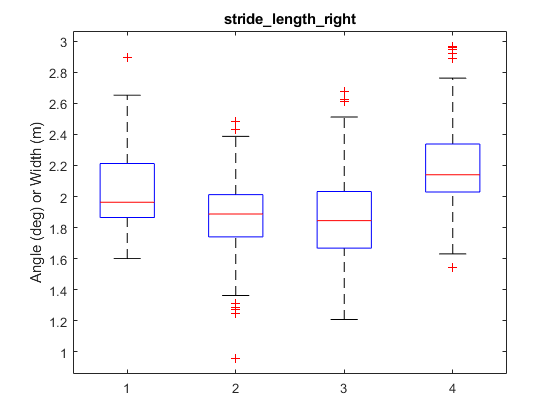

In [53]:
for i = 1:length(topi)
    figure; hold on;
    boxplot(table2array(arr_testt(:,subcols(topi(i)))),T_test);
    title(subcols(topi(i)),'Interpreter','none')
    ylabel('Angle (deg) or Width (m)')
end

<center>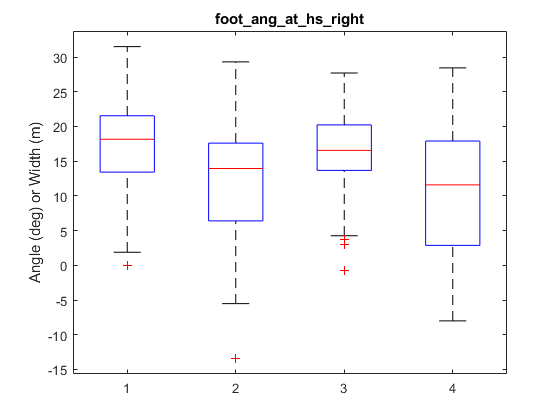</center>


<center>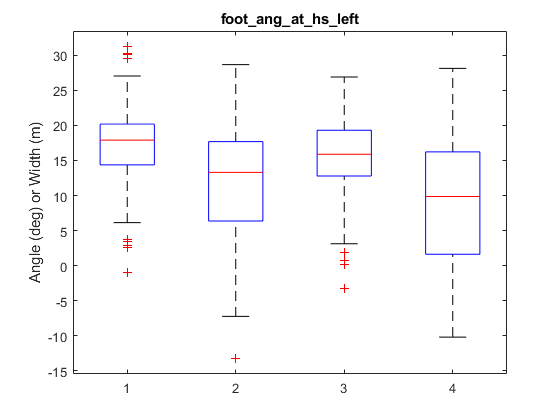</center>


<center>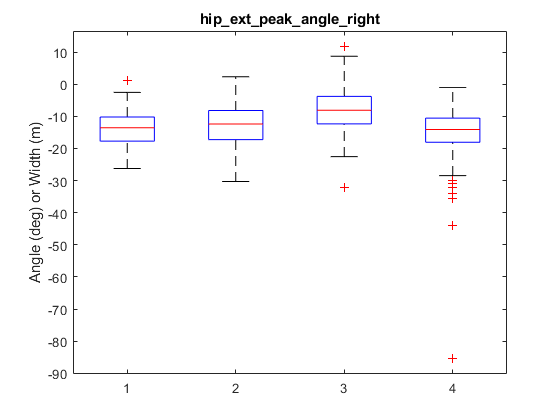</center>


<center>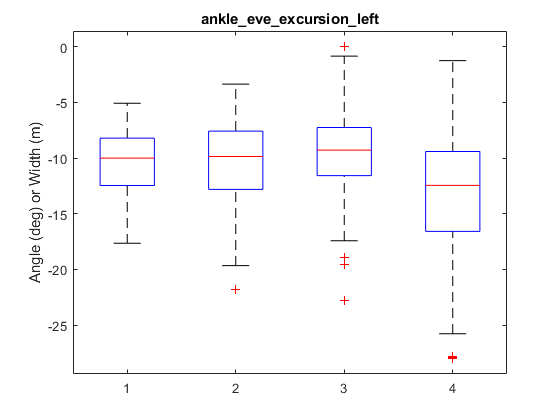</center>


<center>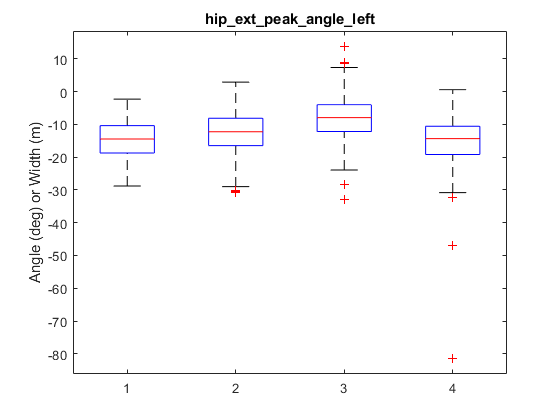</center>


<center>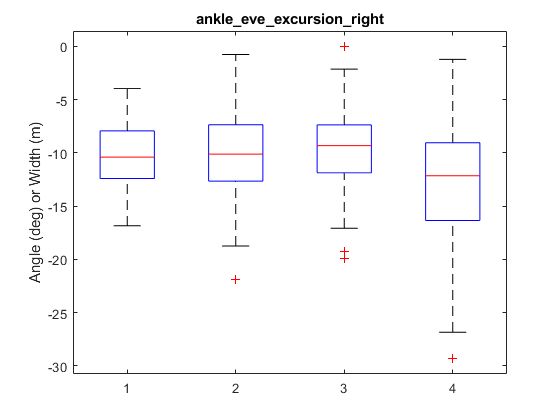</center>


<center>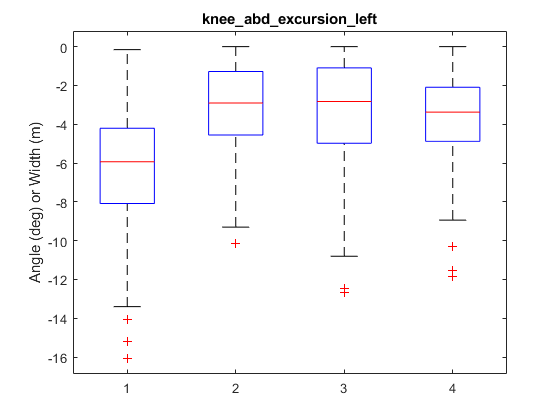</center>


<center>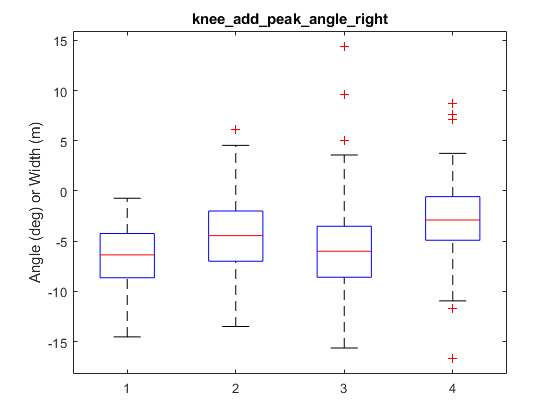</center>



In [54]:
% Determine any significant differences in original vars among groups
for i = 1:length(demcols)
    display(demcols{i})
    [~,tbl,sta] = kruskalwallis(table2array(arr_testt(:,demcols{i})),T_test,'off');
    display(tbl)
    if tbl{2,6} < 0.05
        mc = multcompare(sta,'Display','off');
        display(mc)
    end
end

Height

Weight

gaitspeed

mc = 6x6
1.0000    2.0000  -75.3245   -2.5055   70.3135    0.9998
2. 0000    3.0000  -66.2134    0.3788   66.9710    1.0000
3. 0000    4.0000    7.8403   76.6034  145.3664    0.0219
    2.0000    3.0000  -54.6759    2.8843   60.4446    0.9992
    2.0000    4.0000   19.0505   79.1089  139.1673    0.0040
    3.0000    4.0000   23.8897   76.2246  128.5594    0.0010
age


From the results of the replicate analysis, similar effects can be observed in both stride length and foot angle at touchdown. In the replicate set, gait speed also demonstrates significant differences between groups, suggesting these may have confounding effects on the biomechanical results. We will not address this in the current tutorial, but future analyses should consider adding these as covariates.



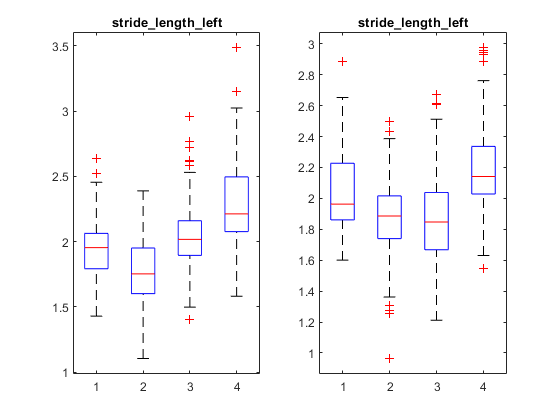

In [55]:
% Compare groups from train and testt
figure; hold on;
subplot(1,2,1);
boxplot(table2array(arr_train(:,'stride_length_left')),T_train);
title('stride_length_left','Interpreter','none');
subplot(1,2,2);
boxplot(table2array(arr_testt(:,'stride_length_left')),T_test);
title('stride_length_left','Interpreter','none');


When comparing results for a single variable, it is apparent that similar groups exist, however, the order of groupings is different between replicates. These clusters could be remapped by minimizing the differences between train and test sets, however, in the current example, we can remap by inspection and observe whether the results are consistent between "train" and "test" sets.


In [56]:
T_train_swap = T_train;
T_train_swap(T_train==1) = 1;
T_train_swap(T_train==3) = 2;
T_train_swap(T_train==4) = 4;
T_train_swap(T_train==2) = 3;


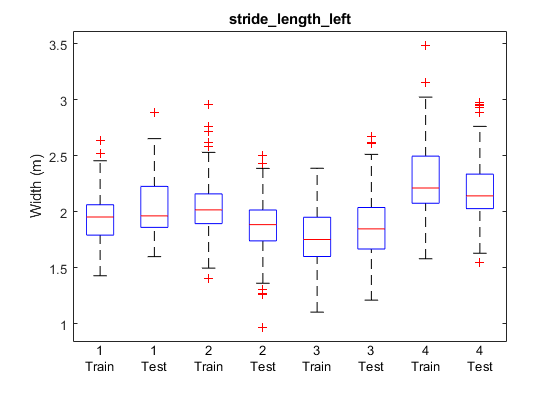

In [57]:
arr = horzcat(vertcat(table2array(arr_train(:,'stride_length_left')),table2array(arr_testt(:,'stride_length_left'))), ...
                vertcat(T_train_swap,T_test));
arr = horzcat(num2cell(arr),vertcat(repmat({'Train'},height(arr_train),1),repmat({'Test'},height(arr_testt),1)));

figure; hold on;
boxplot(cell2mat(arr(:,1)),{cell2mat(arr(:,2)),arr(:,3)});
title('stride_length_left','Interpreter','none');
ylabel('Width (m)')


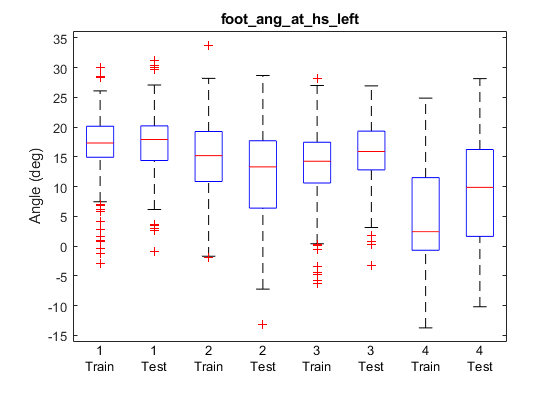

In [58]:
arr = horzcat(vertcat(table2array(arr_train(:,'foot_ang_at_hs_left')),table2array(arr_testt(:,'foot_ang_at_hs_left'))), ...
                vertcat(T_train_swap,T_test));
arr = horzcat(num2cell(arr),vertcat(repmat({'Train'},height(arr_train),1),repmat({'Test'},height(arr_testt),1)));

figure; hold on;
boxplot(cell2mat(arr(:,1)),{cell2mat(arr(:,2)),arr(:,3)});
title('foot_ang_at_hs_left','Interpreter','none');
ylabel('Angle (deg)')


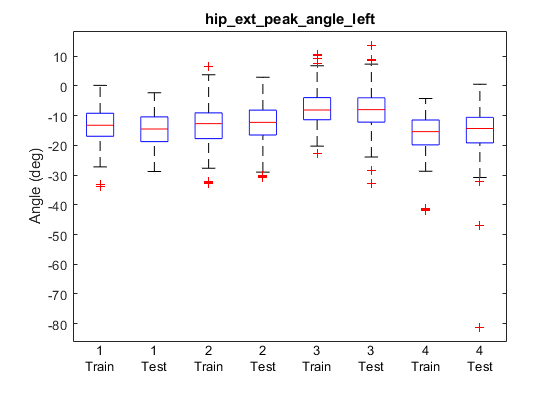

In [59]:
arr = horzcat(vertcat(table2array(arr_train(:,'hip_ext_peak_angle_left')),table2array(arr_testt(:,'hip_ext_peak_angle_left'))), ...
                vertcat(T_train_swap,T_test));
arr = horzcat(num2cell(arr),vertcat(repmat({'Train'},height(arr_train),1),repmat({'Test'},height(arr_testt),1)));

figure; hold on;
boxplot(cell2mat(arr(:,1)),{cell2mat(arr(:,2)),arr(:,3)});
title('hip_ext_peak_angle_left','Interpreter','none');
ylabel('Angle (deg)')


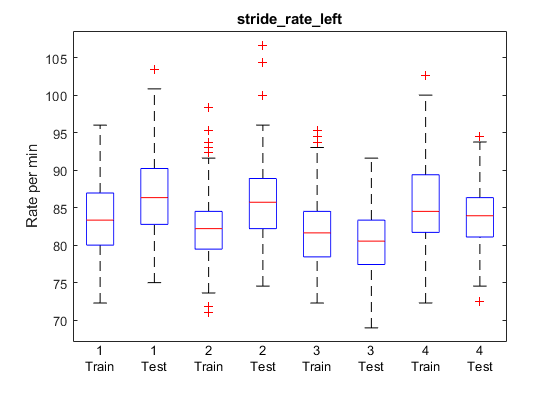

In [60]:
arr = horzcat(vertcat(table2array(arr_train(:,'stride_rate_left')),table2array(arr_testt(:,'stride_rate_left'))), ...
                vertcat(T_train_swap,T_test));
arr = horzcat(num2cell(arr),vertcat(repmat({'Train'},height(arr_train),1),repmat({'Test'},height(arr_testt),1)));

figure; hold on;
boxplot(cell2mat(arr(:,1)),{cell2mat(arr(:,2)),arr(:,3)});
title('stride_rate_left','Interpreter','none');
ylabel('Rate per min')


The results for certain variables are qualitatively consistent between our two replicate data sets. This implies that the pattern observed for runners who demonstrate longer strides and midfoot/rearfoot striking patterns while maintaining lower stride frequency may be a universal pattern that can be observed in other samples of runners. Further analysis is required to understand how these strategies might be influenced by gait speed or other underlying factors.

### Interpretation

The following observations were made from this tutorial.

-  Using a one\-class SVM, we were able to discard outliers from the dataset accounting for the multivariate and non\-normal nature of the data
-  A replicated HCA analysis of the discrete variables demonstrated repeatable sub\-patterns in running kinematics that may define common biomechanical strategies that are worthy of further investigation
-  The confounding effects of gait speed cannot be ruled out, and future work should consider these factors in more detail
### References

\[1\] Kolukula, S. (2018, April 16). How to divide a data set randomly into training and testing data set? MATLAB Answers \- MATLAB Central. Retrieved April 27, 2023, from https://www.mathworks.com/matlabcentral/answers/395136\-how\-to\-divide\-a\-data\-set\-randomly\-into\-training\-and\-testing\-data\-set


\[2\] Trujillo\-Ortiz, Antonio (2009). HZmvntest  (https://www.mathworks.com/matlabcentral/fileexchange/17931\-hzmvntest), MATLAB Central File Exchange. Retrieved Dec 29, 2022.


\[3\] Christophe Leys, Christophe Ley, Olivier Klein, Philippe Bernard, Laurent Licata, Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median, Journal of Experimental Social Psychology, Volume 49, Issue 4, 2013, Pages 764\-766, ISSN 0022\-1031, https://doi.org/10.1016/j.jesp.2013.03.013.


\[4\] Zhao M, Ma L, Jia X, Yan DM, Huang T. GraphReg: Dynamical Point Cloud  Registration With Geometry\-Aware Graph Signal Processing. IEEE Trans  Image Process. 2022;31:7449\-7464. doi: 10.1109/TIP.2022.3223793. Epub  2022 Dec 8. PMID: 36446012.


\[5\] Schölkopf B, Platt JC, Shawe\-Taylor J, Smola AJ, Williamson RC. Estimating the  support of a high\-dimensional distribution. Neural Comput. 2001  Jul;13(7):1443\-71. doi: 10.1162/089976601750264965. PMID: 11440593.


\[6\] Phinyomark A, Osis S, Hettinga BA, Ferber R. Kinematic gait patterns in healthy runners: A hierarchical cluster analysis. J Biomech. 2015 Nov 5;48(14):3897\-904. doi: 10.1016/j.jbiomech.2015.09.025. Epub 2015 Oct 3. PMID: 26456422.


\[7\] Ichimura D, Amma R, Hisano G, Murata H, Hobara H. Spatiotemporal gait patterns in individuals with unilateral transfemoral amputation: A hierarchical cluster analysis. PLoS One. 2022 Dec 22;17(12):e0279593. doi: 10.1371/journal.pone.0279593. PMID: 36548294; PMCID: PMC9778493.


\[8\] Groppe, David (2012).  Bonferroni\-Holm Correction for Multiple Comparisons  (https://www.mathworks.com/matlabcentral/fileexchange/28303\-bonferroni\-holm\-correction\-for\-multiple\-comparisons),  MATLAB Central File Exchange.  Retrieved Dec 29, 2022.


\[9\] van der Geest, Jos (2019). permpos  (https://www.mathworks.com/matlabcentral/fileexchange/11216\-permpos), MATLAB Central File Exchange.  Retrieved Dec 29, 2022.


\[10\] Trujillo\-Ortiz, Antonio (2007). tmcomptest  (https://www.mathworks.com/matlabcentral/fileexchange/15499\-tmcomptest), MATLAB Central File Exchange. Retrieved Dec 30, 2022.


\[11\] Forrester, S.E., Townend, J. (2015). The effect of running velocity on footstrike angle – A curve\-clustering approach, Gait & Posture, Volume 41, Issue 1, Pages 26\-32, ISSN 0966\-6362, https://doi.org/10.1016/j.gaitpost.2014.08.004.

